A ideia é...

In [3]:
from utils.data import Data

VPT_DATA_FILE = './data/vpt__2019_3_24_16_21_38.dat'

vpt_data = Data(VPT_DATA_FILE)
separated_data = vpt_data.get_data()

Estes dados separados são dados de fluxo e volume respiratório que foram coletados com nosso dispositivo. Essas curvas em específico contém 3 tipos de exercícios de Reeducação Ventilatória.

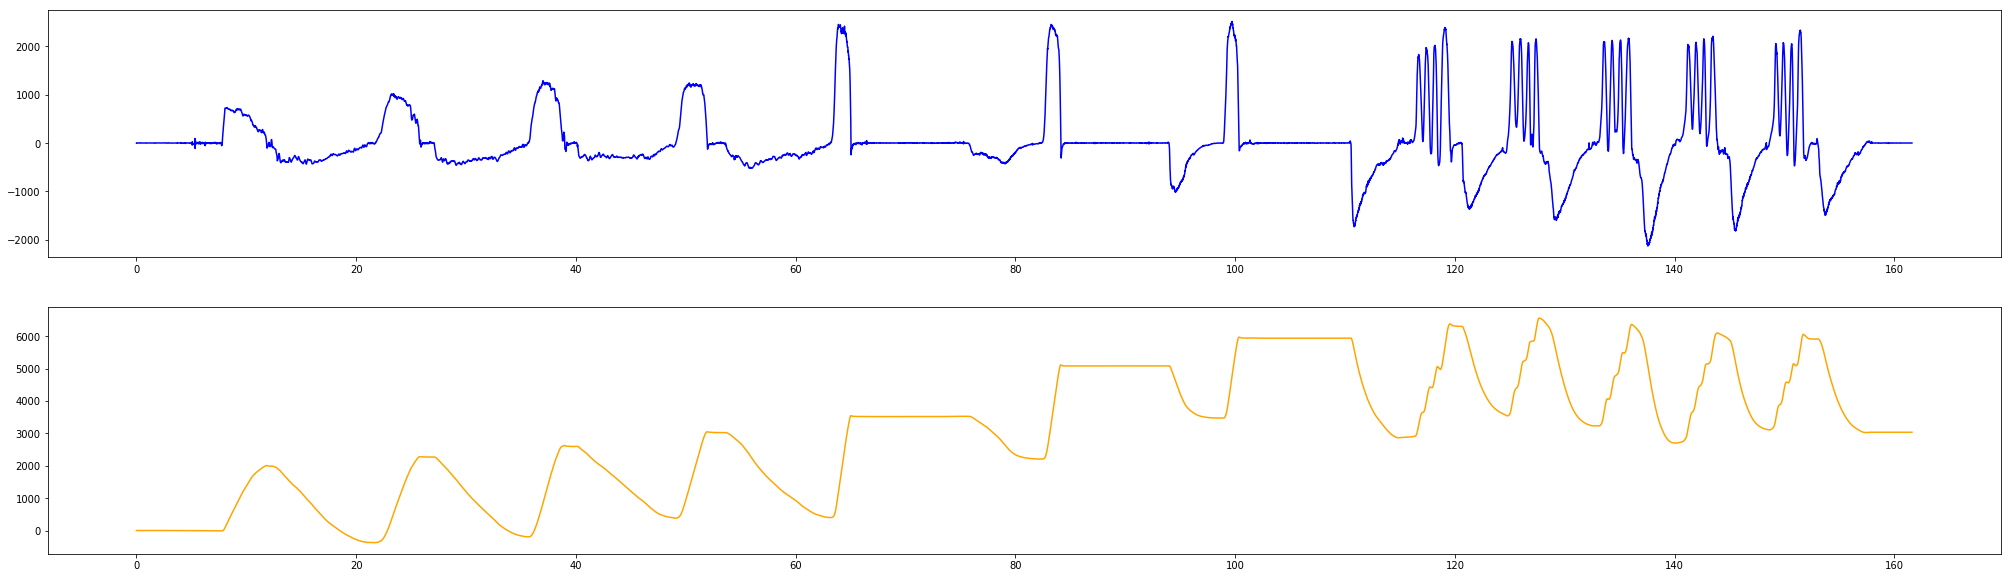

In [13]:
import matplotlib.pyplot as plt

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(35,10))
ax1.plot(separated_data["time"], separated_data["flow"], color="blue", linestyle='solid')
ax2.plot(separated_data["time"], separated_data["volume"], color="orange", linestyle='solid')
plt.show()

Para classificar os exercícios contidos nessa coleta, é necessário separar os ciclos respiratórios. A classe Ventilatory foi criada para lidar com processamentos relacionados a mecânica respiratória e essa separação de ciclos está inclusa na classe.

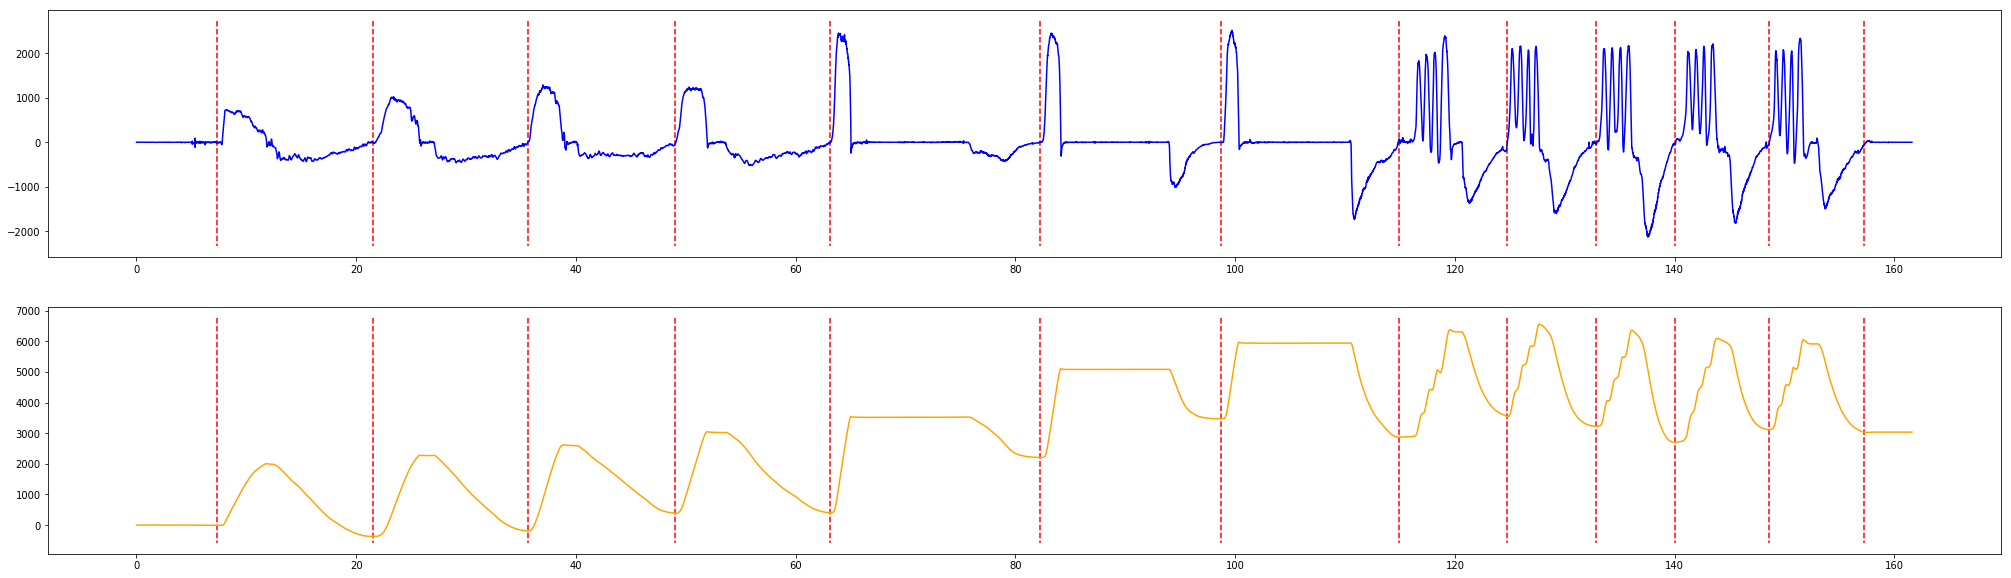

In [23]:
from utils.ventilatory import Ventilatory
import numpy as np

flow_cycles_delimiters = Ventilatory.get_cycles(vpt_data)

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(35,10))
ax1.plot(separated_data["time"], separated_data["flow"], color="blue", linestyle='solid')
ax1.vlines(separated_data["time"][flow_cycles_delimiters], np.max(separated_data["flow"])+200, np.min(separated_data["flow"])-200, color="red", linestyle='dashed')
ax2.plot(separated_data["time"], separated_data["volume"], color="orange", linestyle='solid')
ax2.vlines(separated_data["time"][flow_cycles_delimiters], np.max(separated_data["volume"])+200, np.min(separated_data["volume"])-200, color="red", linestyle='dashed')
plt.show()

Percebemos, no gráfico acima, as 3 classes bem evidentes:

CLASSE 1 = Ciclos 1 ao 4

CLASSE 2 = Ciclos 5 ao 7

CLASSE 3 = Ciclos 8 ao 12

Para esse exemplo, vou utilizar um dos ciclos como modelo e compará-lo com os demais. Se o ciclo testado for daquela classe, ele deve ter a menor distância em relação ao modelo da classe. Durante os experimentos, a normalização dos dados entre -1 e 1 deram melhores resultados e, portanto, já será considerada no exemplo também.

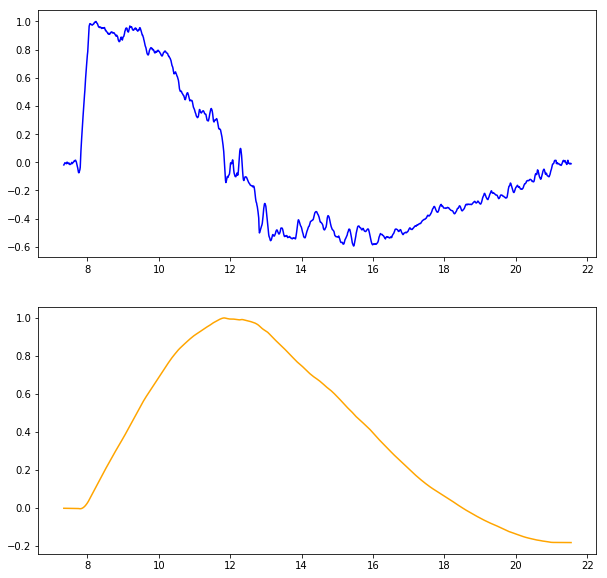

In [28]:
bottom = flow_cycles_delimiters[0]
upper = flow_cycles_delimiters[1]

flow_cycle_model = separated_data["flow"][bottom:upper]/max(abs(np.max(separated_data["flow"][bottom:upper])), abs(np.min(separated_data["flow"][bottom:upper])))
volume_cycle_model = separated_data["volume"][bottom:upper]/max(abs(np.max(separated_data["volume"][bottom:upper])), abs(np.min(separated_data["volume"][bottom:upper])))

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,10))
ax1.plot(separated_data["time"][bottom:upper], flow_cycle_model, color="blue", linestyle='solid')
ax2.plot(separated_data["time"][bottom:upper], volume_cycle_model, color="orange", linestyle='solid')
plt.show()

Agora, comparemos esse modelo com os ciclos restantes dessa coleta. Para essa primeira comparação, utilizou-se o método `fastdtw`. Aproveitaremos também para medir o tempo gasto nessas comparações.

In [62]:
from classifier.comparator import Comparator
from time import time

def analyse(separated_data, selected_cycle=0, method='fastdtw'):
    bottom = flow_cycles_delimiters[selected_cycle]
    upper = flow_cycles_delimiters[selected_cycle+1]

    flow_cycle_model = separated_data["flow"][bottom:upper]/max(abs(np.max(separated_data["flow"][bottom:upper])), abs(np.min(separated_data["flow"][bottom:upper])))
    volume_cycle_model = separated_data["volume"][bottom:upper]/max(abs(np.max(separated_data["volume"][bottom:upper])), abs(np.min(separated_data["volume"][bottom:upper])))

    total_elapsed_time = 0
    elapsed_times = []

    flow_dists = []
    volume_dists = []
    flow_vol_dists = []

    for i in range(0, len(flow_cycles_delimiters)-1):
        t0 = time()
        bottom = flow_cycles_delimiters[i]
        upper = flow_cycles_delimiters[i+1]

        flow_cycle = separated_data["flow"][bottom:upper]/max(abs(np.max(separated_data["flow"][bottom:upper])), abs(np.min(separated_data["flow"][bottom:upper])))
        volume_cycle = separated_data["volume"][bottom:upper]/max(abs(np.max(separated_data["volume"][bottom:upper])), abs(np.min(separated_data["volume"][bottom:upper])))

        flow_distance = Comparator.compare(flow_cycle_model, flow_cycle, method=method)
        volume_distance = Comparator.compare(volume_cycle_model, volume_cycle, method=method)

        flow_dists.append(flow_distance)
        volume_dists.append(volume_distance)
        flow_vol_dists.append(flow_distance + volume_distance)

        dt = time() - t0
        elapsed_times.append(dt)
        total_elapsed_time += dt

        print('flow_distance =', "{0: 20.15f}".format(flow_distance), end=' | ')        
        print('volume_distance =', "{0: 20.15f}".format(volume_distance), end=' | ')
        print('sum_distance =', "{0: 20.15f}".format(flow_distance + volume_distance), end=' | ')
        print('elapsed_time =', "{0: 20.15f}".format(dt))

    print('\nmean_elapsed_time_per_comparison =', np.mean(elapsed_times))
    print('total_elapsed_time =', total_elapsed_time)

    cycles_inds = np.arange(1, len(flow_cycles_delimiters))

    f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(25,15))

    bars = ax1.bar(cycles_inds, flow_dists)

    for bar in bars:
        bar.set_facecolor('b')

    ax1.set_xticks(cycles_inds)
    ax1.set_xticklabels(['Cycle ' + str(cycle_ind) for cycle_ind in cycles_inds])
    ax1.set_ylabel('Distance from model')
    ax1.set_title('Flow Distances')

    bars = ax2.bar(cycles_inds, volume_dists)

    for bar in bars:
        bar.set_facecolor('r')

    ax2.set_xticks(cycles_inds)
    ax2.set_xticklabels(['Cycle ' + str(cycle_ind) for cycle_ind in cycles_inds])
    ax2.set_ylabel('Distance from model')
    ax2.set_title('Volume Distances')

    bars = ax3.bar(cycles_inds, flow_vol_dists)

    for bar in bars:
        bar.set_facecolor('g')

    ax3.set_xticks(cycles_inds)
    ax3.set_xticklabels(['Cycle ' + str(cycle_ind) for cycle_ind in cycles_inds])
    ax3.set_ylabel('Distance from model')
    ax3.set_title('Flow + Volume Distances')

    plt.show()

flow_distance =    0.000000000000000 | volume_distance =    0.000000000000000 | sum_distance =    0.000000000000000 | elapsed_time =    1.414078474044800
flow_distance =   46.819225086668432 | volume_distance =   30.865897716260953 | sum_distance =   77.685122802929385 | elapsed_time =    1.492095232009888
flow_distance =  131.318006359204844 | volume_distance =   94.961557449735707 | sum_distance =  226.279563808940566 | elapsed_time =    1.610061407089233
flow_distance =   55.050446927141472 | volume_distance =   95.948370995222206 | sum_distance =  150.998817922363685 | elapsed_time =    1.502662658691406
flow_distance =  207.910693978422017 | volume_distance =  363.497884131411013 | sum_distance =  571.408578109833002 | elapsed_time =    1.950186491012573
flow_distance =   70.092602939298573 | volume_distance =  446.602027520427839 | sum_distance =  516.694630459726454 | elapsed_time =    1.620056867599487
flow_distance =   52.329675986248660 | volume_distance =  346.98212609282569

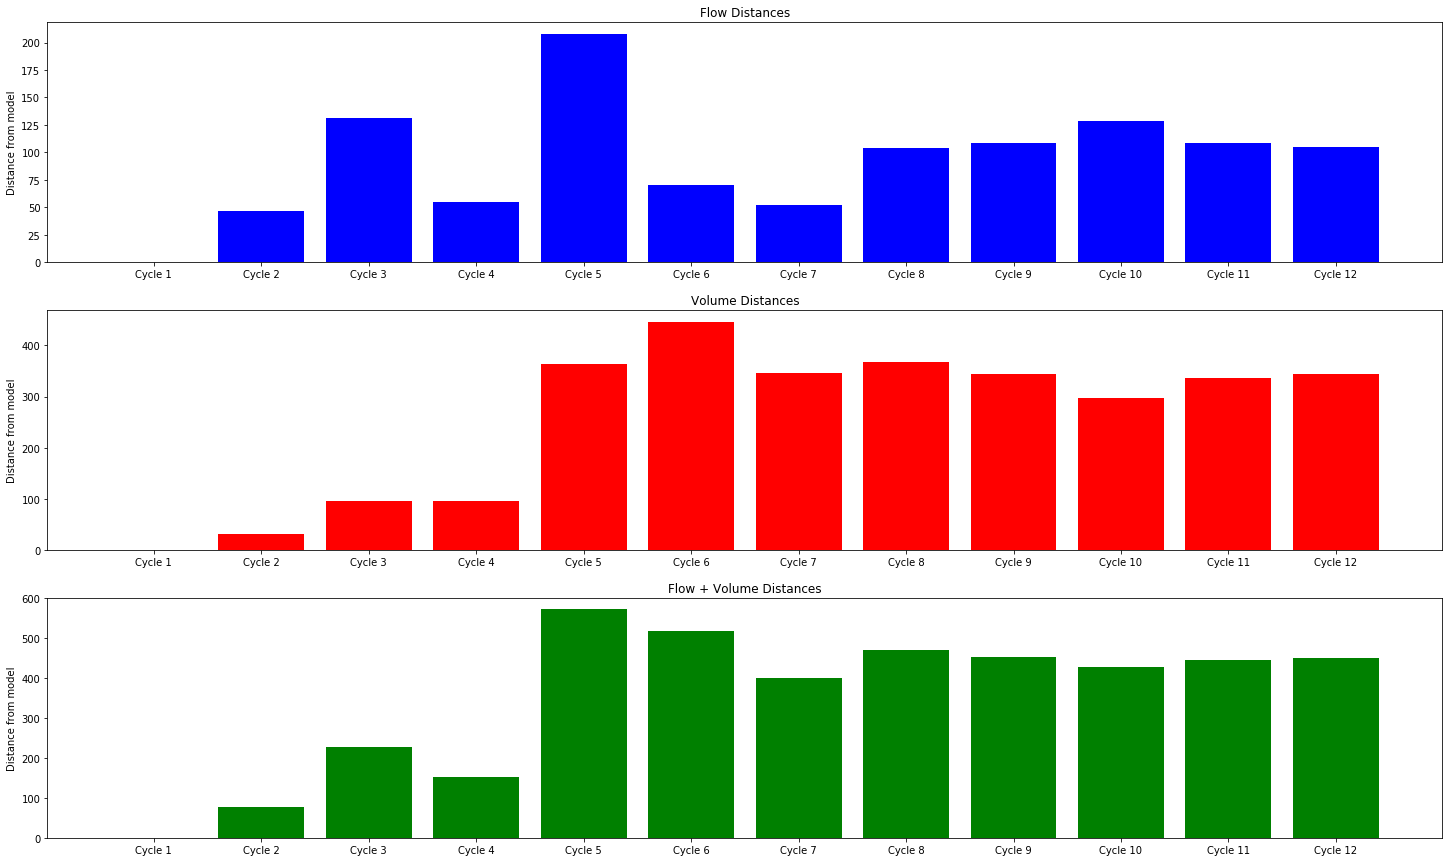

In [63]:
analyse(separated_data, selected_cycle=0, method='fastdtw')

O Volume e o Fluxo + Volume parecem ser duas curvas boas para se comparar os modelos, pois se comportaram da forma que esperávamos: Ciclo 1 ao 4 com as menores distâncias já que são da mesma classe. Mas temos que analisar o comportamento para os outros modelos também. Então vamos selecionar o Ciclo 6 e o Ciclo 9 como modelos dos outros exercícios e verificar quais melhores medidas de distância.

flow_distance =   70.092602939298573 | volume_distance =  446.602027520427839 | sum_distance =  516.694630459726454 | elapsed_time =    1.605726003646851
flow_distance =   18.151442079791632 | volume_distance =  399.966933537962632 | sum_distance =  418.118375617754282 | elapsed_time =    1.497535943984985
flow_distance =   33.221906564767409 | volume_distance =  241.603680277726198 | sum_distance =  274.825586842493635 | elapsed_time =    1.740369319915771
flow_distance =   12.537061856102765 | volume_distance =  252.746754466041324 | sum_distance =  265.283816322144105 | elapsed_time =    1.909531116485596
flow_distance =   31.590272150883241 | volume_distance =   35.045251997144760 | sum_distance =   66.635524148027997 | elapsed_time =    3.401173591613770
flow_distance =    0.000000000000000 | volume_distance =    0.000000000000000 | sum_distance =    0.000000000000000 | elapsed_time =    2.263543367385864
flow_distance =   19.651638261972398 | volume_distance =   47.95811019012872

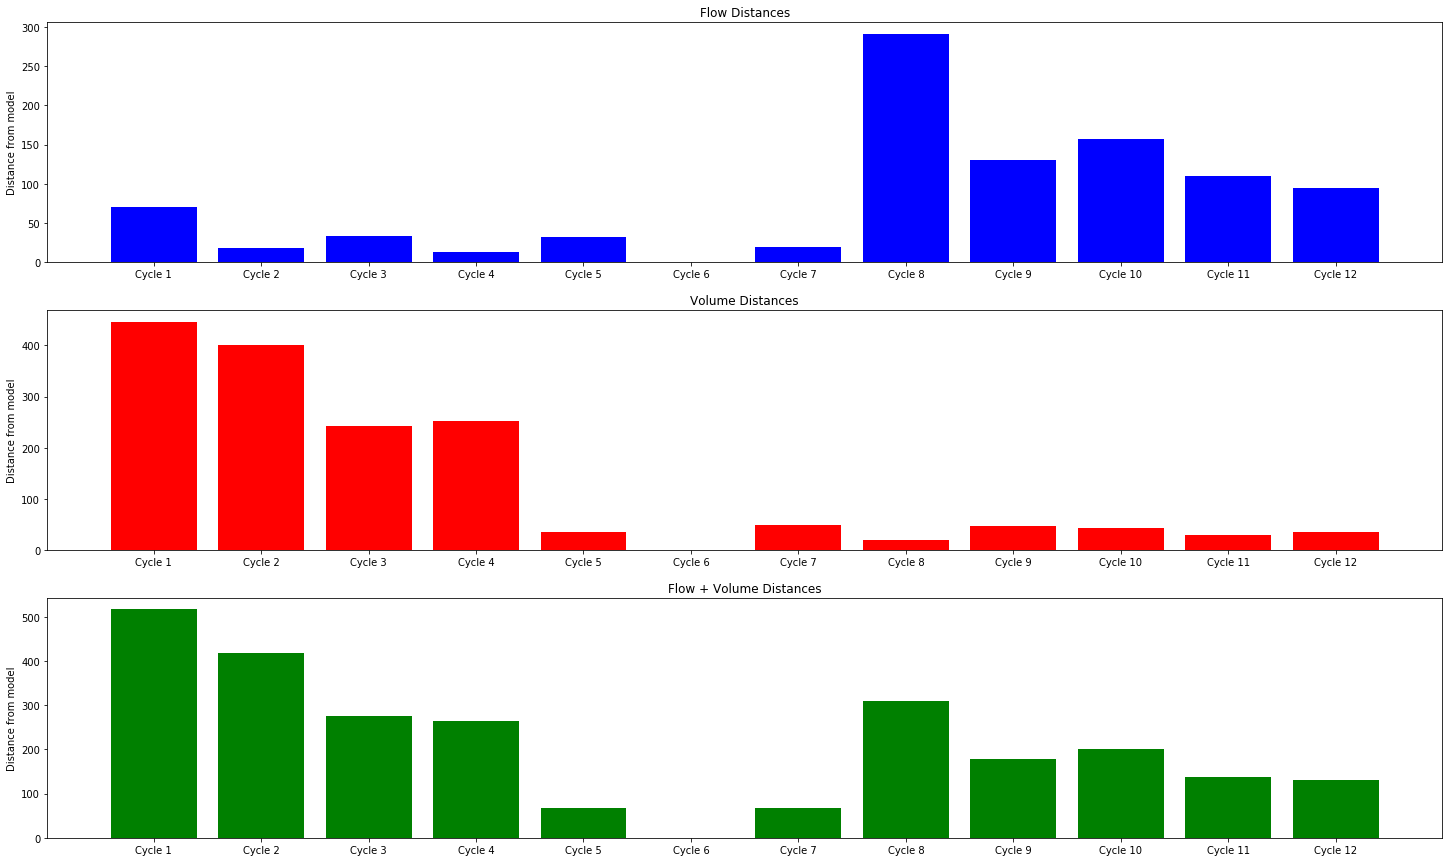

In [64]:
analyse(separated_data, selected_cycle=5, method='fastdtw')

flow_distance =  108.080182811090452 | volume_distance =  345.121577229564309 | sum_distance =  453.201760040654790 | elapsed_time =    1.297934532165527
flow_distance =  104.619277997427361 | volume_distance =  313.758542749493529 | sum_distance =  418.377820746920861 | elapsed_time =    1.153453111648560
flow_distance =  151.169644045468942 | volume_distance =  164.854473860352471 | sum_distance =  316.024117905821413 | elapsed_time =    1.619038581848145
flow_distance =  113.693578548319337 | volume_distance =  155.598699736974481 | sum_distance =  269.292278285293833 | elapsed_time =    1.322448492050171
flow_distance =  268.180659416196818 | volume_distance =   58.491344026032500 | sum_distance =  326.672003442229311 | elapsed_time =    1.600842475891113
flow_distance =  130.814551416970318 | volume_distance =   46.560015544595679 | sum_distance =  177.374566961565989 | elapsed_time =    1.482472181320190
flow_distance =  105.621768871518185 | volume_distance =    2.46079327624265

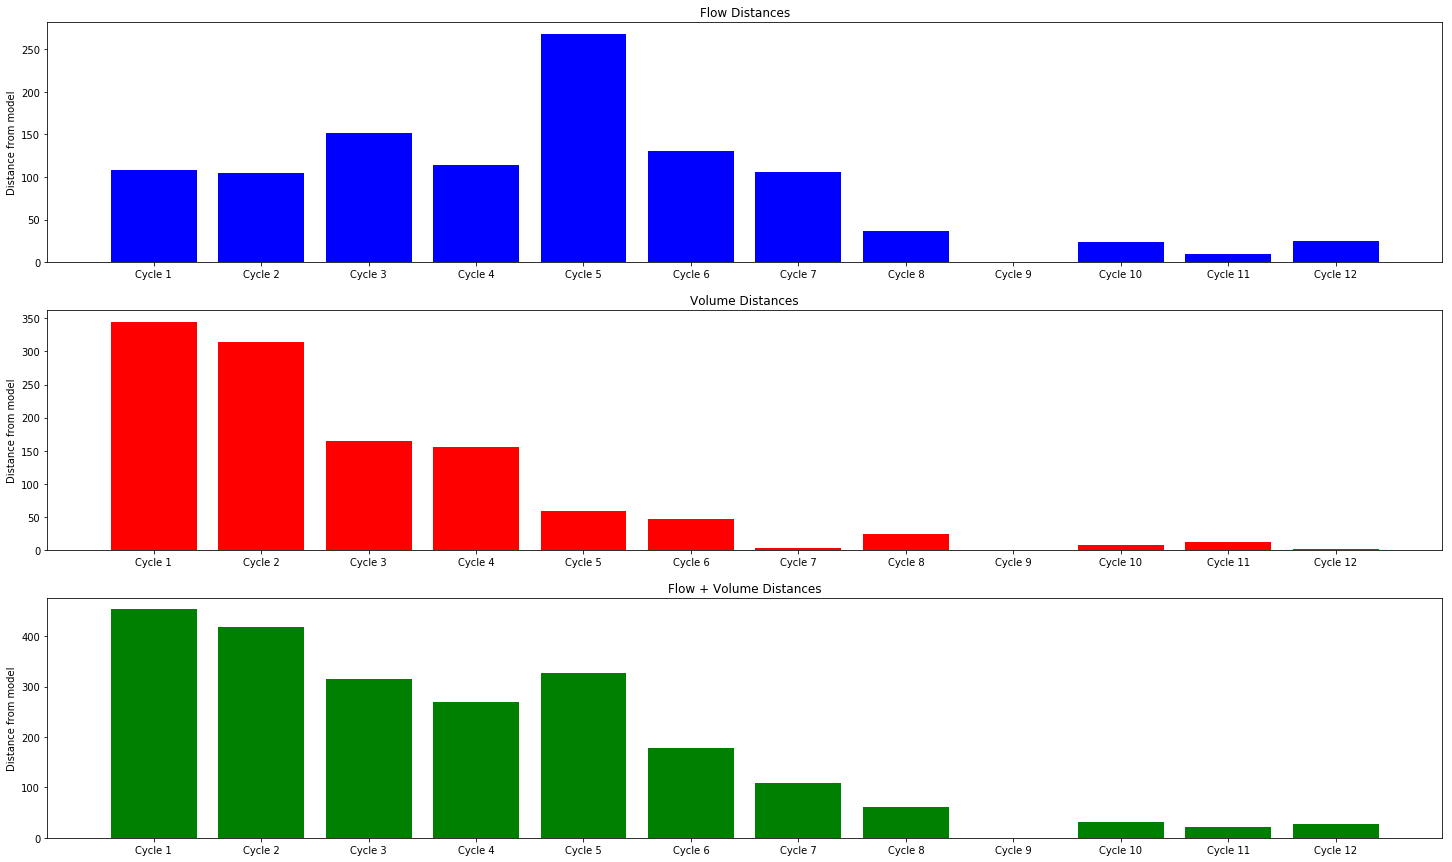

In [65]:
analyse(separated_data, selected_cycle=8, method='fastdtw')

Com esses dois outros modelos, percebe-se que a curva de volume não se saí tão bem nas comparações, sendo necessária informações da curva de fluxo também para diferenciar as classes. Portanto, até o momento com os experimentos realiazdos, a distância composta do fluxo + volume é a melhor medida para classificar os exercícios terapêuticos respiratórios.

Além do método `fastdtw`, outros métodos estão sendo levados em consideração. Tais como:

- Distância de Minkwoski
- Distância de Mahalanobis
- Dynamic Time Warping (DTW)
- Edit Distance on Real sequences (EDR)
- Longest Common Subsequence (LCSS)
- Time Warp Edit Distance (TWED)
- Minimum Jump Costs (MJC)

Os algoritmos dão bons resultados seguindo a mesma ideia exposta acima, obviamente alguns dão resultados melhores que outros, mas, no geral, a classe é escolhida a partir da menor distância do fluxo + volume. A grande diferença entre elas está no tempo de execução. Até o presente momento, sob o critério de tempo de execução, o MJC foi o que teve o melhor resultado (~ 100 ms por comparação), enquanto o DTW puro foi o pior (~ 80 segs por comparação).

flow_distance =    0.000000000000000 | volume_distance =    0.000000000000000 | sum_distance =    0.000000000000000 | elapsed_time =    0.081425666809082
flow_distance =    0.000018834216793 | volume_distance =    0.000012897384204 | sum_distance =    0.000031731600997 | elapsed_time =    0.090859174728394
flow_distance =    0.000000457387530 | volume_distance =    0.453349323741367 | sum_distance =    0.453349781128897 | elapsed_time =    0.140678405761719
flow_distance =    0.000033232117781 | volume_distance =    0.024993011367613 | sum_distance =    0.025026243485393 | elapsed_time =    0.114321947097778
flow_distance =    0.001558535049950 | volume_distance =   10.528326571981923 | sum_distance =   10.529885107031873 | elapsed_time =    0.298132896423340
flow_distance =    0.001495481790538 | volume_distance =    3.448884759134550 | sum_distance =    3.450380240925088 | elapsed_time =    0.223483800888062
flow_distance =    0.000584676261067 | volume_distance =    0.23342568197550

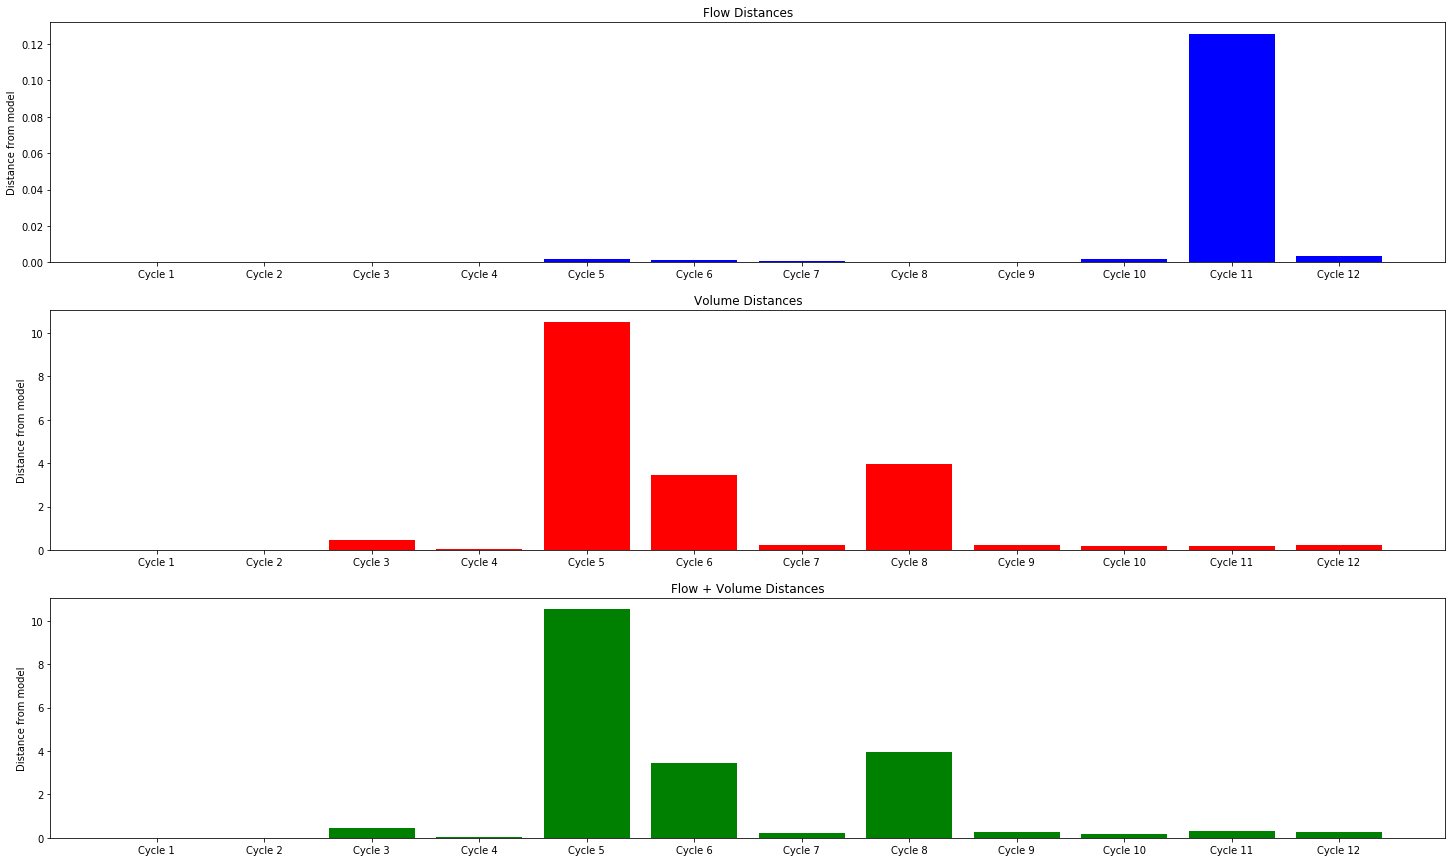

In [66]:
analyse(separated_data, selected_cycle=0, method='mjc')

flow_distance =    0.000000000000000 | volume_distance =    0.000000000000000 | sum_distance =    0.000000000000000 | elapsed_time =  118.502767324447632
flow_distance =    0.015308404770508 | volume_distance =    0.010925981492482 | sum_distance =    0.026234386262990 | elapsed_time =  124.112180948257446
flow_distance =    0.044030816866271 | volume_distance =    0.034331727205255 | sum_distance =    0.078362544071527 | elapsed_time =  113.819691896438599
flow_distance =    0.018302981963436 | volume_distance =    0.033938775367673 | sum_distance =    0.052241757331109 | elapsed_time =   84.110390424728394
flow_distance =    0.057036169005460 | volume_distance =    0.108854759665589 | sum_distance =    0.165890928671049 | elapsed_time =  101.679821729660034
flow_distance =    0.017902647761953 | volume_distance =    0.145690895640225 | sum_distance =    0.163593543402179 | elapsed_time =   87.054114103317261
flow_distance =    0.011202267988611 | volume_distance =    0.11383850220369

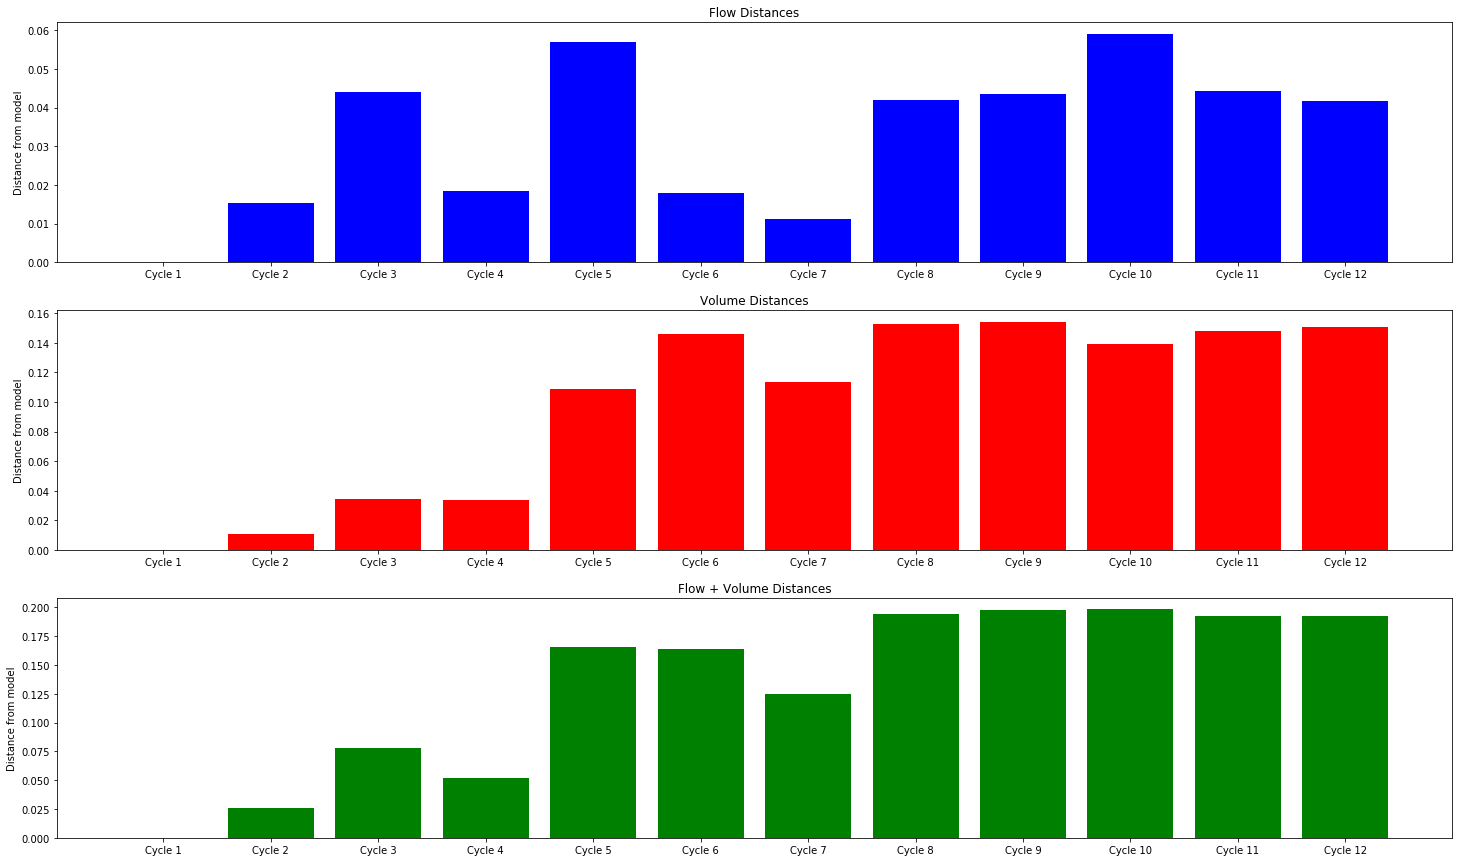

In [67]:
analyse(separated_data, selected_cycle=0, method='dtw')